# Análisis de series temporales

## Importaciones y carga de datos

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
warnings.filterwarnings("ignore")
# Cargamos el dataset
data = sm.datasets.co2.load_pandas().data
type(data)

pandas.core.frame.DataFrame

## Preprocesado

### Imputación de valores perdidos

In [2]:
data = data.interpolate(method='spline', order=1)
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


### Re-muestreo

1958-03-31    316.100000
1958-04-30    317.200000
1958-05-31    316.768137
1958-06-30    315.825601
1958-07-31    315.625000
                 ...    
2001-08-31    369.425000
2001-09-30    367.880000
2001-10-31    368.050000
2001-11-30    369.375000
2001-12-31    371.020000
Freq: ME, Name: co2, Length: 526, dtype: float64


pandas.core.series.Series

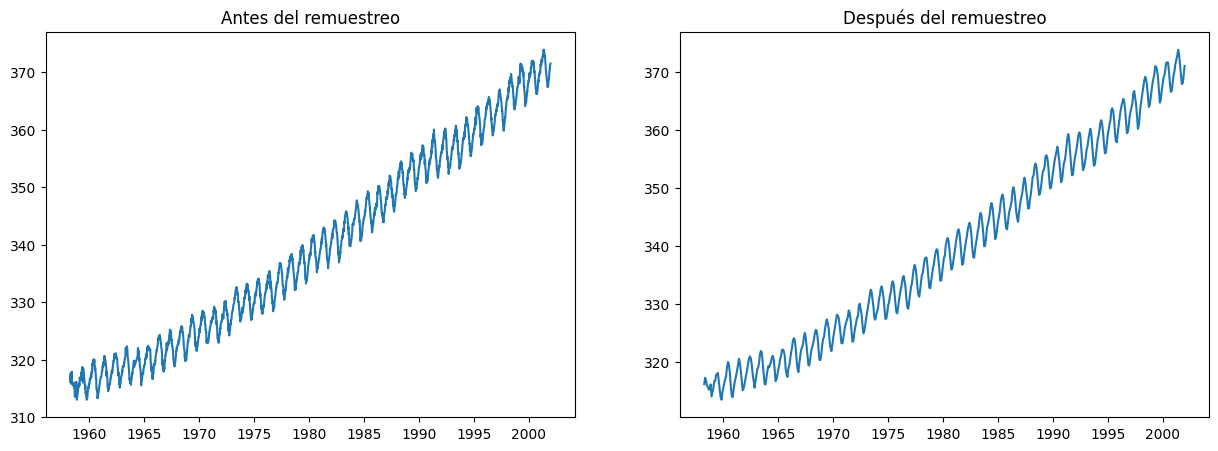

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Observamos antes del remuestreo...
ax1.plot(data)
ax1.set_title(label="Antes del remuestreo")

#... y después
y = data['co2'].resample('M').mean()
ax2.plot(y)
ax2.set_title(label="Después del remuestreo")
print(y)
type(y)

### Descomposición estacional

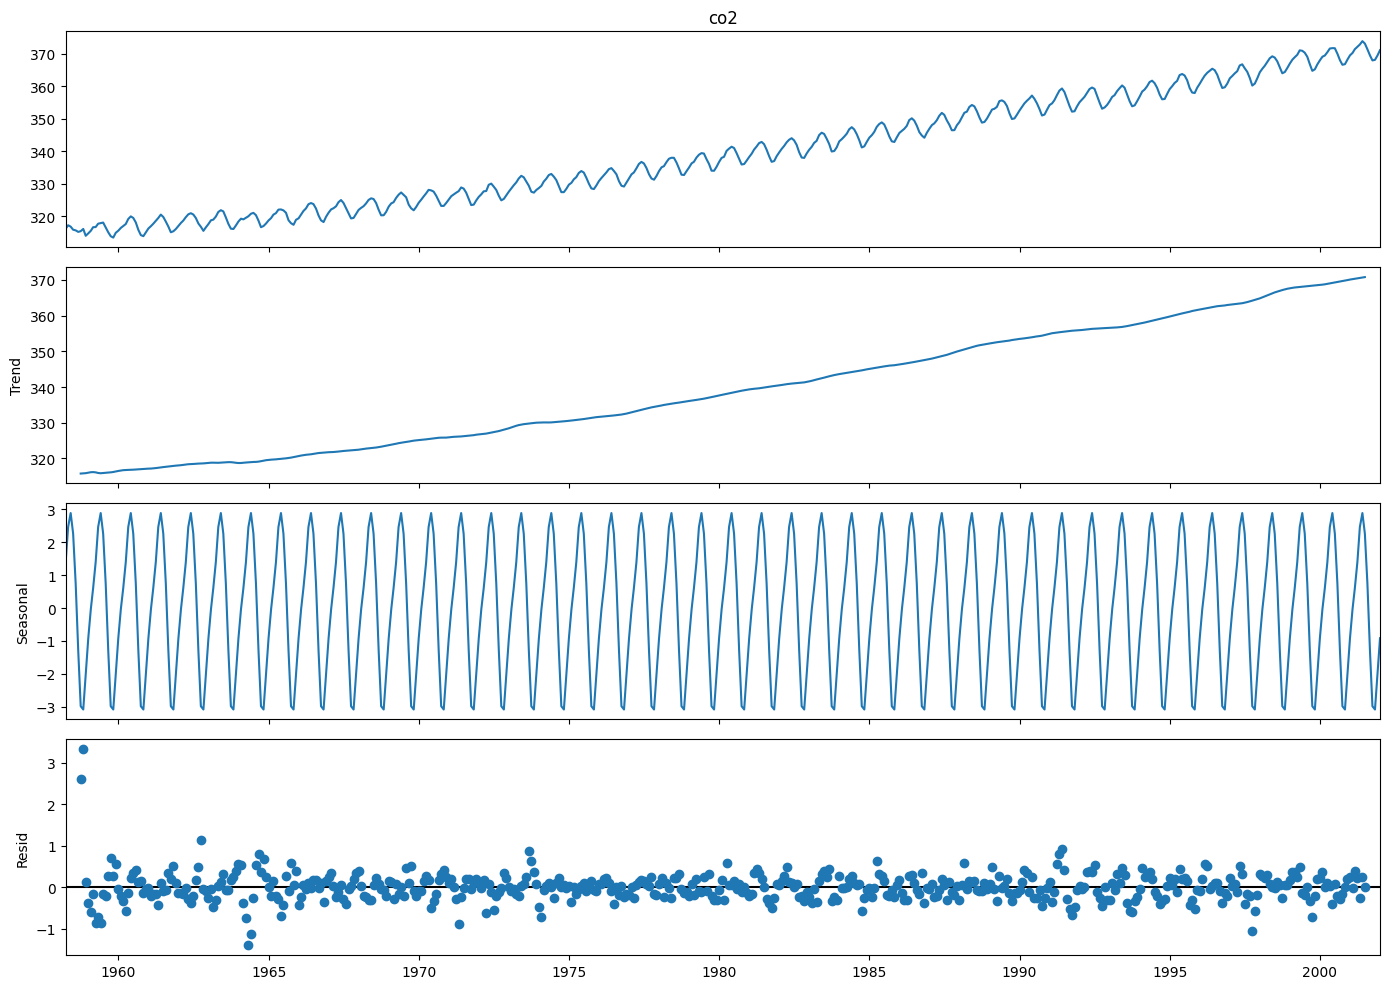

In [4]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14,10)
fig.tight_layout()
plt.show()

## ARIMA

In [5]:

y_train = y[:'1991-01-31']
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]
# Ajuste de hiperparámetros
mejor = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False,
                                            enforce_stationarity=False)
            results = mod.fit(disp=False, maxiter=200)
            if results.aic < mejor:
                mejor = results.aic
                mejores_parametros = [param, param_seasonal]
                print('Mejor ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Mejor ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5695.0012542331615
Mejor ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5047.675162778218
Mejor ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4893.9188874463425
Mejor ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1339.6459861575152
Mejor ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1116.4242071720378
Mejor ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1020.4156243549509
Mejor ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:983.616515169592
Mejor ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:743.7518627006846
Mejor ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:686.6583597459155
Mejor ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:675.2082515734305
Mejor ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:636.7090189237293
Mejor ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:585.0500967780125
Mejor ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:512.6021355794643
Mejor ARIMA(0, 0, 1)x(1, 2, 2, 12)12 - AIC:484.6720203405813
Mejor ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:462.4868284336115
Mejor ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:418.22458169229526
Mejor ARIMA(0, 0, 2

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  395
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 -83.295
Date:                            Sat, 20 Dec 2025   AIC                            182.589
Time:                                    12:58:06   BIC                            213.854
Sample:                                03-31-1958   HQIC                           195.010
                                     - 01-31-1991                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2663      0.291      4.355      0.000       0.696       1.836
ar.L2         -0.2690      0.290   

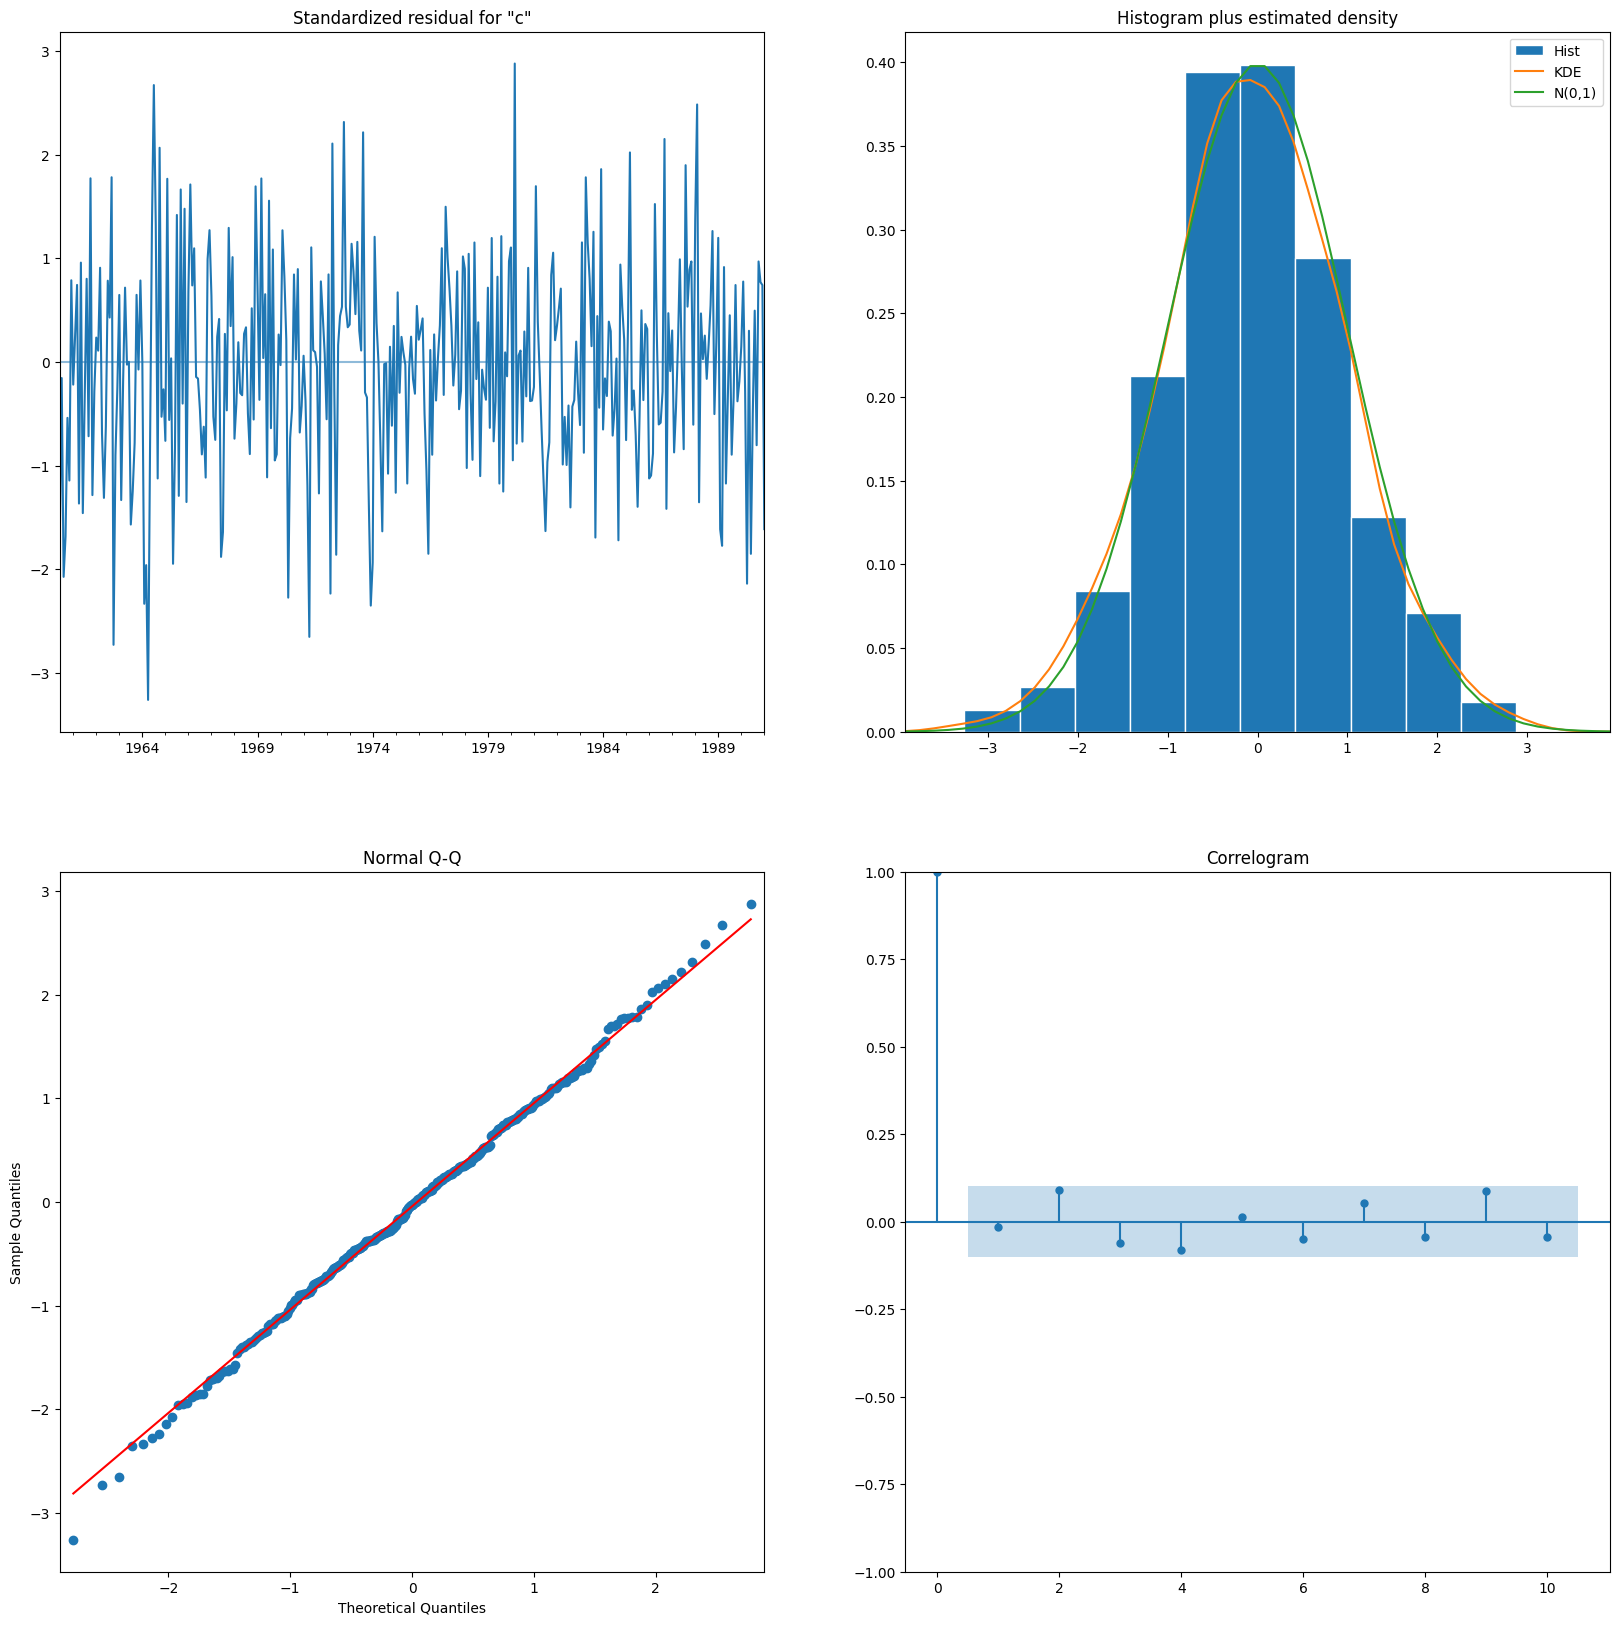

In [6]:
# Ajuste del modelo
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=mejores_parametros[0],
                                seasonal_order=mejores_parametros[1],
                                enforce_invertibility=False,
								enforce_stationarity=False)
results = mod.fit()
print(results.summary().tables[0])
print(results.summary().tables[1])
print(results.summary().tables[2])
results.plot_diagnostics(figsize=(20, 20))
plt.show()

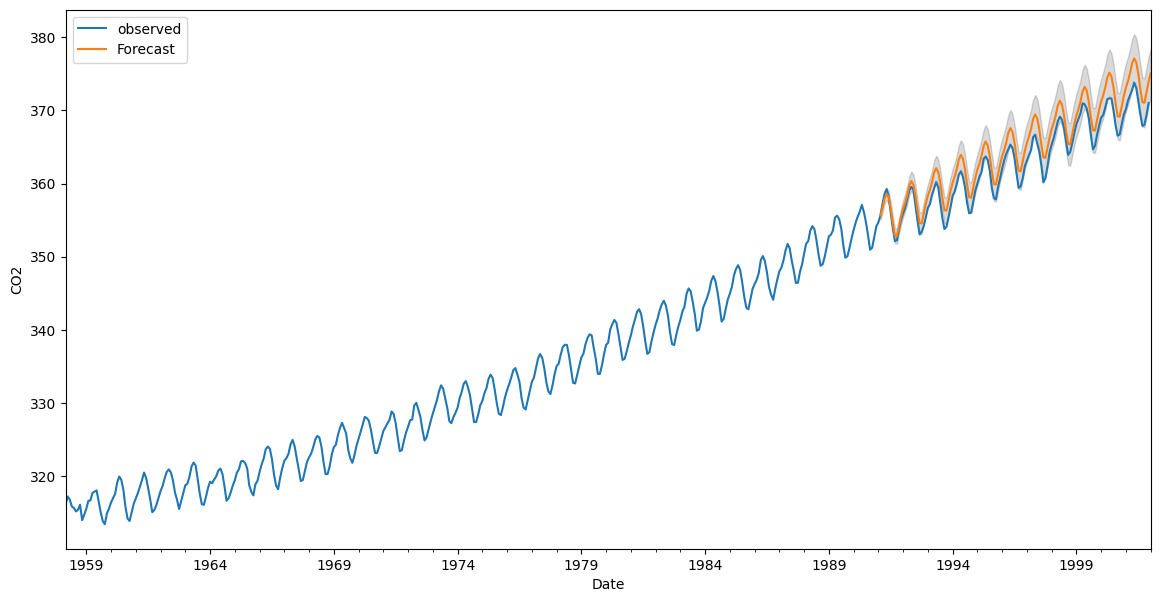

In [7]:
# Predicción a múltiples pasos
pred_uc = results.get_forecast(steps=132)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date')
ax.set_ylabel('CO2')
plt.legend()
plt.show()

In [8]:
y_truth = y['1991-02-28':]
predicciones_arima = pred_uc.predicted_mean[y_truth.index]

mse = ((predicciones_arima - y_truth) ** 2).mean()
rele = ((np.abs(predicciones_arima - y_truth)/y_truth)*100).mean()
print('Error cuadrático medio ARIMA {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM ARIMA {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio ARIMA {}'.format(round(rele, 2)))
type(y_truth)

Error cuadrático medio ARIMA 4.85
Raíz cuadrada de ECM ARIMA 2.2
Error porcentual medio ARIMA 0.56


pandas.core.series.Series

## Holt-Winters

In [9]:
hw_model = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=12).fit()
predicciones_hw = hw_model.forecast(132)

In [10]:
mse = ((predicciones_hw - y_truth) ** 2).mean()
rele = (np.abs(predicciones_hw - y_truth)/y_truth*100).mean()
print('Error cuadrático medio HW {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM HW {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio HW {}'.format(round(rele, 2)))

Error cuadrático medio HW 4.11
Raíz cuadrada de ECM HW 2.03
Error porcentual medio HW 0.44


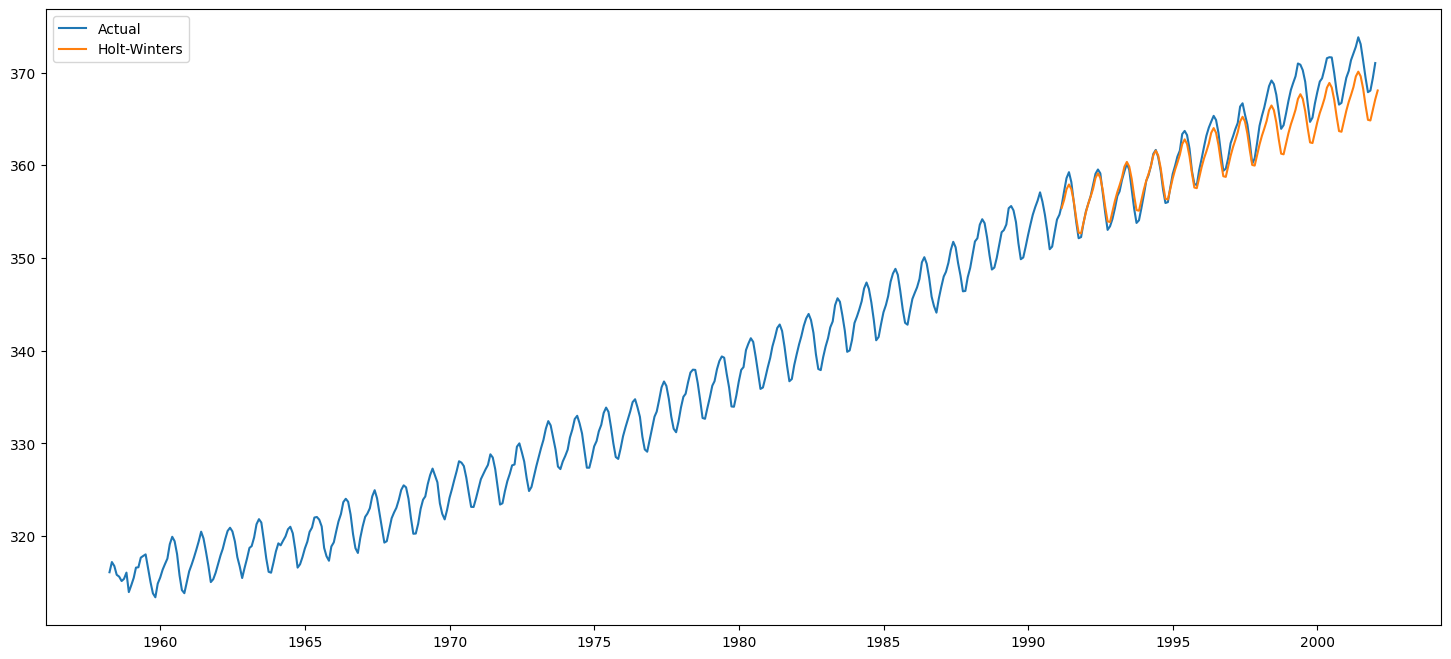

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.plot(y, label="Actual")
plt.plot(predicciones_hw, label="Holt-Winters")
plt.legend()
plt.show()

## Prophet

In [36]:
# Prophet
from prophet import Prophet
model = Prophet(interval_width=0.95)
y_prophet = pd.DataFrame(y)
y_prophet = y_prophet.reset_index()
y_prophet.columns = ['ds', 'y']

y_train = y_prophet[y_prophet['ds'] <= '1991-01-31']
y_truth = y_prophet[y_prophet['ds'] >  '1991-01-31']

print(y_train)
model.fit(y_train)
forecast = model.make_future_dataframe(
    periods=132, freq='ME')
forecast = model.predict(forecast)

13:19:07 - cmdstanpy - INFO - Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing


            ds           y
0   1958-03-31  316.100000
1   1958-04-30  317.200000
2   1958-05-31  316.768137
3   1958-06-30  315.825601
4   1958-07-31  315.625000
..         ...         ...
390 1990-09-30  350.940000
391 1990-10-31  351.225000
392 1990-11-30  352.700000
393 1990-12-31  354.140000
394 1991-01-31  354.675000

[395 rows x 2 columns]


ds
1991-02-28    355.650
1991-03-31    357.200
1991-04-30    358.600
1991-05-31    359.250
1991-06-30    358.180
               ...   
2001-08-31    369.425
2001-09-30    367.880
2001-10-31    368.050
2001-11-30    369.375
2001-12-31    371.020
Name: y, Length: 131, dtype: float64
Error cuadrático medio PROPHET 3.6402
Raíz cuadrada de ECM PROPHET 1.9079
Error porcentual medio PROPHET 0.4934


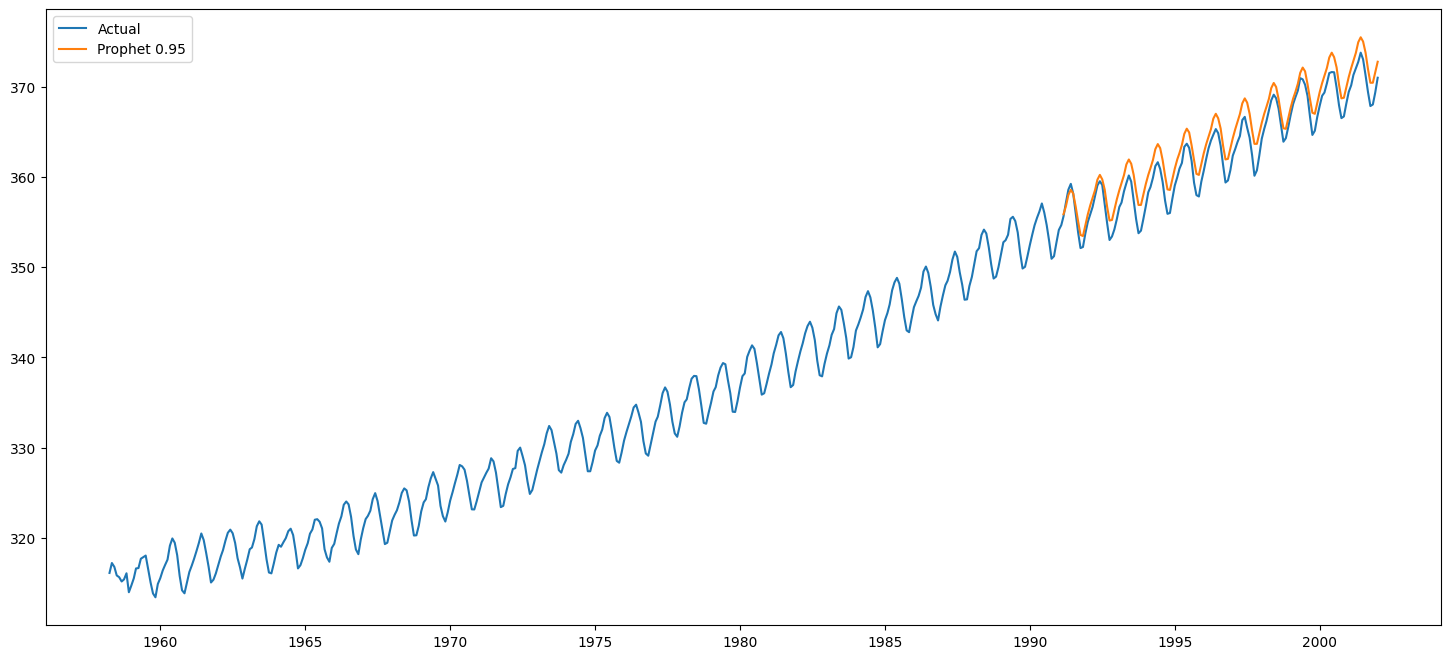

In [37]:
y_truth = y_truth.set_index('ds')['y']
print(y_truth)
forecast.set_index("ds", inplace=True)
predicciones_prophet = forecast.loc[y_truth.index, "yhat"]
mse = ((predicciones_prophet - y_truth) ** 2).mean()
rele = (np.abs(predicciones_prophet - y_truth)/y_truth*100).mean()
print('Error cuadrático medio PROPHET {}'.format(round(mse, 4)))
print('Raíz cuadrada de ECM PROPHET {}'.format(round(np.sqrt(mse), 4)))
print('Error porcentual medio PROPHET {}'.format(round((rele), 4)))

plt.plot(y, label="Actual")
plt.plot(predicciones_prophet, label="Prophet 0.95")
plt.legend()
plt.show()

In [38]:
model = Prophet(interval_width=0.9)
y_prophet = pd.DataFrame(y)
y_prophet = y_prophet.reset_index()
y_prophet.columns = ['ds', 'y']

y_train = y_prophet[y_prophet['ds'] <= '1991-01-31']
y_truth = y_prophet[y_prophet['ds'] >  '1991-01-31']

print(y_train)
model.fit(y_train)
forecast = model.make_future_dataframe(
    periods=132, freq='ME')
forecast = model.predict(forecast)

13:19:07 - cmdstanpy - INFO - Chain [1] start processing


            ds           y
0   1958-03-31  316.100000
1   1958-04-30  317.200000
2   1958-05-31  316.768137
3   1958-06-30  315.825601
4   1958-07-31  315.625000
..         ...         ...
390 1990-09-30  350.940000
391 1990-10-31  351.225000
392 1990-11-30  352.700000
393 1990-12-31  354.140000
394 1991-01-31  354.675000

[395 rows x 2 columns]


13:19:07 - cmdstanpy - INFO - Chain [1] done processing


ds
1991-02-28    355.650
1991-03-31    357.200
1991-04-30    358.600
1991-05-31    359.250
1991-06-30    358.180
               ...   
2001-08-31    369.425
2001-09-30    367.880
2001-10-31    368.050
2001-11-30    369.375
2001-12-31    371.020
Name: y, Length: 131, dtype: float64
Error cuadrático medio PROPHET 3.6402
Raíz cuadrada de ECM PROPHET 1.9079
Error porcentual medio PROPHET 0.4934


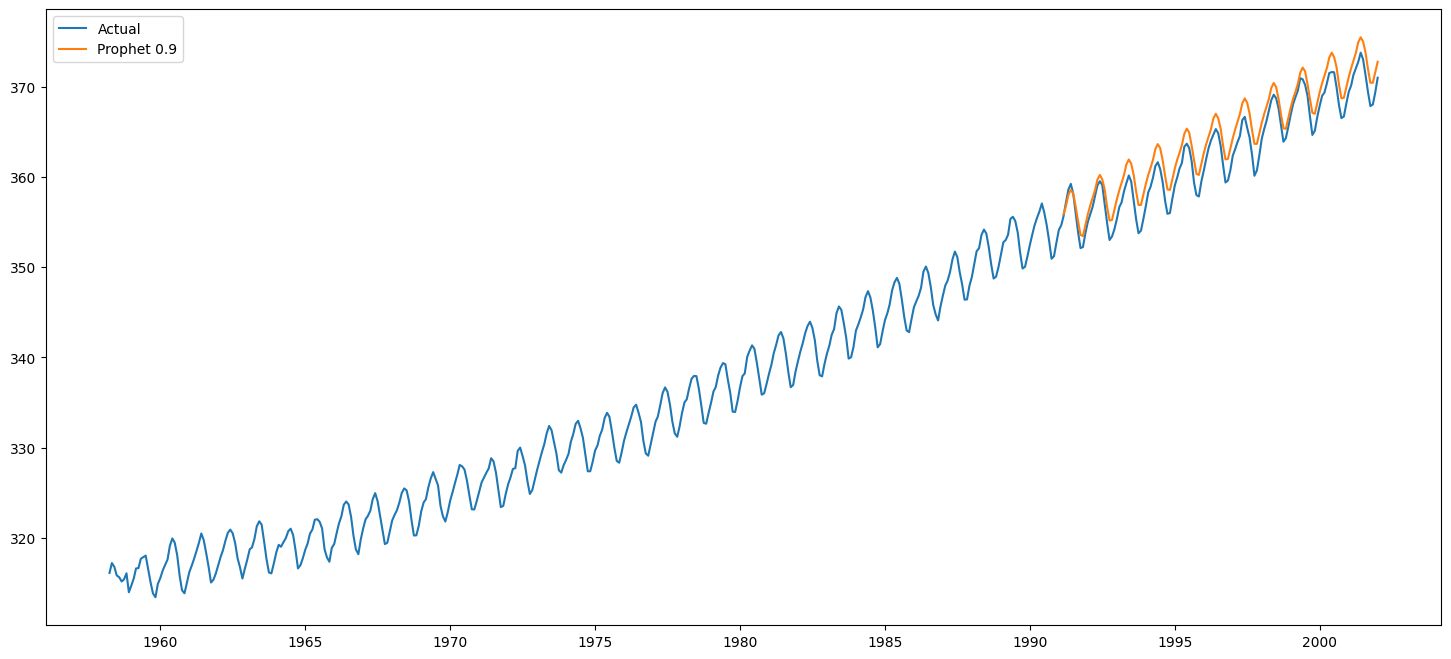

In [39]:
y_truth = y_truth.set_index('ds')['y']
print(y_truth)
forecast.set_index("ds", inplace=True)
predicciones_prophet = forecast.loc[y_truth.index, "yhat"]
mse = ((predicciones_prophet - y_truth) ** 2).mean()
rele = (np.abs(predicciones_prophet - y_truth)/y_truth*100).mean()
print('Error cuadrático medio PROPHET {}'.format(round(mse, 4)))
print('Raíz cuadrada de ECM PROPHET {}'.format(round(np.sqrt(mse), 4)))
print('Error porcentual medio PROPHET {}'.format(round((rele), 4)))

plt.plot(y, label="Actual")
plt.plot(predicciones_prophet, label="Prophet 0.9")
plt.legend()
plt.show()